## Вариант 1

##### ~~**Шаг 1** (max 1 балл).~~
Возьмите свой датасет из дз 1 и превратите его в «типологическую» матрицу, в строках которой будут синсеты, в столбцах - слова,
а на их пересечении - 0, если слово не относится к данному синсету, и 1, если относится.
##### ~~**Шаг 2** (max 2 балла).~~
Сократите размерность этой матрицы до 2 методом [MDS](https://github.com/dashapopova/CompSem2023/blob/main/Semantic%20maps/CompSem_plot_mds.ipynb),
визуализируйте результат.
##### ~~**Шаг 3** (max 2 балла).~~
Проанализируйте то, что у вас получилось. Видны ли какие-то закономерности? Стали ли заметны какие-то новые закономерности, которые не были видны раньше,
когда вы строили граф? Какие синсеты оказались ближе друг к другу, а какие дальше друг от друга? Кажется ли вам этот результат осмысленным?
##### ~~**Шаг 4** (max 3 балла).~~
Поставьте каждому синсету в соответствие одно русское слово (вручную), возьмите любую модель с  http://vectors.nlpl.eu/, вытащите оттуда вектора соответствующих слов,
соберите их в одну матрицу и проделайте с ней то же, что и с «типологической» матрицей: сократите размерность до 2 методом MDS и визуализируйте результат. 
##### ~~**Шаг 5** (max 1 балл).~~
Сравните две картинки: соответствует ли взаимное расположение синсетов на «типологической» карте взаимному расположению относящихся к ним русских слов
в дистрибутивной модели?
##### ~~**Шаг 6** (бонусный, max 1 балл).~~
Можно посчитать попарные косинусные расстояния между всеми строками в каждой из матриц, а потом измерить [коэффициент корреляции Пирсона](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html)
между этими двумя наборами данных.


In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=0ca31211d961506066110d9e8794daf47f3a4b47fa2a0ae040d003199c9d6a44
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [4]:
import nltk
from nltk.corpus import wordnet as wn
import numpy as np
import wget
import zipfile

In [5]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### **Шаг 1**

In [7]:
like_exemplar = wn.synset('like.v.01')

In [8]:
like_dictionary = dict()
for language in wn.langs():
    if like_exemplar.lemma_names(language):
        like_dictionary[language] = like_exemplar.lemma_names(language)

In [9]:
synsets_dictionary = dict()
synsets_list = []
lemmas = []
lemma_synset = []
for language in like_dictionary:
    for word in like_dictionary[language]:
        for lemma in wn.lemmas(word, lang=language):
            pair = (lemma.name(), lemma.synset().name())
            if lemma.name() not in lemmas:
                lemmas.append(lemma.name())
            if pair not in lemma_synset:
                lemma_synset.append(pair)
            synsets_dictionary.setdefault(lemma.synset().name(), 0)
            synsets_dictionary[lemma.synset().name()] += 1
for syns in synsets_dictionary:
    if synsets_dictionary[syns] > 3:
        synsets_list.append(syns)

In [10]:
matrix = np.zeros((len(synsets_list), len(lemmas)), dtype=np.int32)

In [11]:
for lm, ss in lemma_synset:
    if ss in synsets_list and lm in lemmas:
        matrix[synsets_list.index(ss)][lemmas.index(lm)] = 1

### **Шаг 2**

In [12]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

In [13]:
embedding = MDS(n_components=2, normalized_stress='auto', dissimilarity='euclidean')

In [14]:
matrix_transformed = embedding.fit_transform(matrix)

In [15]:
pairs = {}
for i, pair in enumerate(matrix_transformed):
    tpl = (round(pair[0], 4), round(pair[1], 4))
    if tpl not in pairs:
        pairs[tpl] = [synsets_list[i]] # чтобы сводить вместе очень близкие векторы
    else:
        pairs[tpl].append(synsets_list[i])

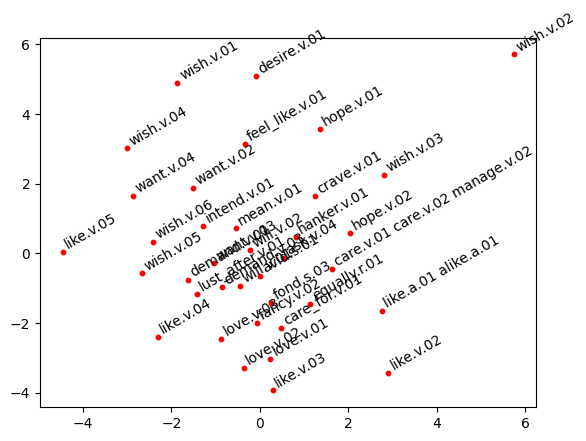

In [16]:
for pair in pairs:
    plt.scatter(pair[0], pair[1], c='red', s=10)
    plt.annotate(' '.join(pairs[pair]), (pair[0], pair[1] + .1), rotation=30)
plt.show()

### **Шаг 3**

*Видны ли какие-то закономерности? Какие синсеты оказались ближе друг к другу, а какие дальше друг от друга?*
1. Сближаются вплоть до почти полного совпадения:<br>
    `care.v.01` (feel concern or interest) + `care.v.02` (provide care for) + `manage.v.02` (be in charge of, act on, or dispose of)<br>
    `like.a.01` (resembling or similar; having the same or some of the same characteristics; often used in combination) + `alike.a.01` (having the same or similar characteristics)
2. Отдельно выделяются:<br>
    `wish.v.02` (prefer or wish to do something),<br>
    `like.v.02` (find enjoyable or agreeable),<br>
    `like.v.05` (want to have),<br>
    `wish.v.04` (feel or express a desire or hope concerning the future or fortune of),<br>
    `desire.v.01` (feel or have a desire for; want strongly) + `wish.v.01` (hope for; have a wish)

Остальные синсеты находятся близко друг к другу в "ядре".

*Стали ли заметны какие-то новые закономерности, которые не были видны раньше, когда вы строили граф?*

Насколько я могу сказать, нет. Зато некоторые суждения хуже видны на полученном графике (например, глаголы романтической привязанности, хотя и находятся близко на графике, в отдельную группу выделяются плохо). Видимо, из-за того, что значения глаголов (и их вектора) очень близки, визуально различить их становится труднее. Однако с этим лучше справлялось автоматическое членение на группы. 

*Кажется ли вам этот результат осмысленным?*

В целом, результат довольно близок к результату графов из ДЗ1. Он осмысленен в некоторых местах, однако в других слишком общий (большое ядро, где все синсеты близки друг к другу) или слишком частный (отдельное выделение некоторых синсетов, которые, в целом, не сильно отстают от ядра). Учитель описал бы это так: "осмысленные вещи есть, но нужно додумать")

### **Шаг 4**

In [ ]:
for sset in synsets_list:
    print(sset, ' '.join(wn.synset(sset).lemma_names()))
    print(wn.synset(sset).definition())
    print()

    wish.v.01 wish → надеяться
    hope for; have a wish

    wish.v.02 wish care like → предпочитать
    prefer or wish to do something

    wish.v.03 wish → желать
    make or express a wish

    wish.v.04 wish wish_well → уповать
    feel or express a desire or hope concerning the future or fortune of

    wish.v.05 wish → хотеть
    order politely; express a wish for

    wish.v.06 wish bid → просить
    invoke upon

    care.v.01 care → заботиться
    feel concern or interest

    care.v.02 care give_care → ухаживать
    provide care for

    manage.v.02 manage deal care handle → отвечать
    be in charge of, act on, or dispose of

    like.v.02 like → нравиться
    find enjoyable or agreeable

    like.v.03 like → увлекаться
    be fond of

    like.v.04 like → считаться
    feel about or towards; consider, evaluate, or regard

    like.v.05 like → хотеть
    want to have

    like.a.01 like similar → похожий
    resembling or similar; having the same or some of the same characteristics; often used in combination

    alike.a.01 alike similar like → сходный
    having the same or similar characteristics

    love.v.01 love → любить
    have a great affection or liking for

    feel_like.v.01 feel_like → склоняться
    have an inclination for something or some activity

    will.v.02 will → определять
    determine by choice

    intend.v.01 intend mean think → намереваться
    have in mind as a purpose

    want.v.04 want → нуждаться
    wish or demand the presence of

    mean.v.01 mean intend → подразумевать
    mean or intend to express or convey

    desire.v.01 desire want → мечтать
    feel or have a desire for; want strongly

    crave.v.01 crave hunger thirst starve lust → жаждать
    have a craving, appetite, or great desire for

    hanker.v.01 hanker long yearn → алкать
    desire strongly or persistently

    demand.v.01 demand → требовать
    request urgently and forcefully

    want.v.03 want → разыскивать
    hunt or look for; want for a particular reason

    fancy.v.02 fancy go_for take_to → воображать
    have a fancy or particular liking or desire for

    hope.v.01 hope trust desire → ожидать
    expect and wish

    want.v.02 want need require → требоваться
    have need of

    love.v.03 love → любить
    be enamored or in love with

    love.v.02 love enjoy → обожать
    get pleasure from

    care_for.v.01 care_for → пристраститься
    have a liking, fondness, or taste (for)

    hope.v.02 hope → предвкушать
    be optimistic; be full of hope; have hopes

    ask.v.04 ask require expect → требовать
    consider obligatory; request and expect

    avid.s.01 avid devouring esurient greedy → жадный
    (often followed by `for') ardently or excessively desirous

    lust_after.v.01 lust_after lech_after → вожделеть
    have a strong sexual desire for

    will.v.01 will → предписывать
    decree or ordain

    demand.v.03 demand exact → заявлять
    claim as due or just

    equally.r.01 equally as every_bit → одинаково
    to the same degree (often followed by `as')

    fond.s.03 fond partial → неравнодушный
    (followed by `of' or `to') having a strong preference or liking for

In [45]:
list_of_russian = {'надеяться_VERB': ['wish.v.01'], 'предпочитать_VERB': ['wish.v.02'], 'желать_VERB': ['wish.v.03'], 
                    'уповать_VERB': ['wish.v.04'], 'хотеть_VERB': ['wish.v.05', 'like.v.05'], 'просить_VERB': ['wish.v.06'], 
                    'заботиться_VERB': ['care.v.01'], 'ухаживать_VERB': ['care.v.02'], 'отвечать_VERB': ['manage.v.02'], 
                    'нравиться_VERB': ['like.v.02'], 'увлекаться_VERB': ['like.v.03'], 'считаться_VERB': ['like.v.04'], 
                    'похожий_ADJ': ['like.a.01'], 'сходный_ADJ': ['alike.a.01'], 'любить_VERB': ['love.v.01', 'love.v.03'], 
                    'склоняться_VERB': ['feel_like.v.01'], 'определять_VERB': ['will.v.02'], 'намереваться_VERB': ['intend.v.01'], 
                    'нуждаться_VERB': ['want.v.04'], 'подразумевать_VERB': ['mean.v.01'], 'мечтать_VERB': ['desire.v.01'], 
                    'жаждать_VERB': ['crave.v.01'], 'алкать_VERB': ['hanker.v.01'], 'требовать_VERB': ['demand.v.01', 'ask.v.04'], 
                    'разыскивать_VERB': ['want.v.03'], 'воображать_VERB': ['fancy.v.02'], 'ожидать_VERB': ['hope.v.01'], 
                    'требоваться_VERB': ['want.v.02'], 'обожать_VERB': ['love.v.02'], 'пристраститься_VERB': ['care_for.v.01'], 
                    'предвкушать_VERB': ['hope.v.02'], 'жадный_ADJ': ['avid.s.01'], 'вожделеть_VERB': ['lust_after.v.01'], 
                    'предписывать_VERB': ['will.v.01'], 'заявлять_VERB': ['demand.v.03'], 'одинаково_ADV':['equally.r.01'], 'неравнодушный_ADJ': ['fond.s.03']}

In [19]:
model_url = 'http://vectors.nlpl.eu/repository/20/220.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]

In [46]:
vectors = {}

with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.txt')
    for line in stream:
        line = line.decode()
        if line.split()[0] in list_of_russian:
            if len(list_of_russian[line.split()[0]]) == 1:
                vectors[line.split()[0]] = np.float_(line.split()[1:])
            else:
                # чтобы не уменьшать размерность, потому что придумать вообше без синонимов у меня не вышло
                vectors[line.split()[0] + '.01'] = np.float_(line.split()[1:])
                vectors[line.split()[0] + '.02'] = np.float_(line.split()[1:])

In [47]:
matrix_russian = np.array(list(vectors.values()))

In [48]:
matrix_russian_transformed = embedding.fit_transform(matrix_russian)

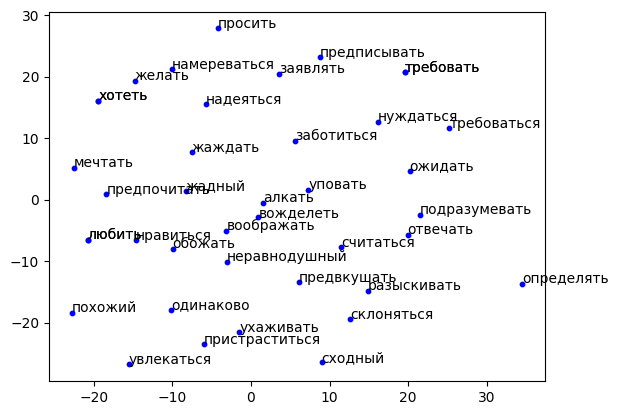

In [49]:
for i, pair in enumerate(matrix_russian_transformed):
    plt.scatter(pair[0], pair[1], c='blue', s=10)
    plt.annotate(list(vectors.keys())[i].split('_')[0], (pair[0], pair[1] + .1))
plt.show()

### **Шаг 5**

Можно заметить, что у двух графиков разный масштаб, поэтому на одном графике показывать их нет смысла...

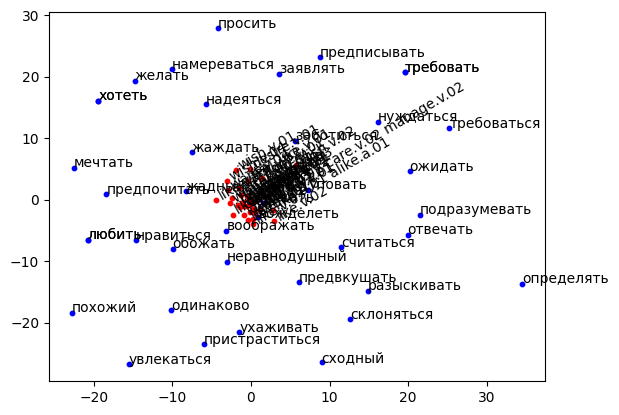

In [65]:
for pair in pairs:
    plt.scatter(pair[0], pair[1], c='red', s=10)
    plt.annotate(' '.join(pairs[pair]), (pair[0], pair[1] + .1), rotation=30)
for i, pair in enumerate(matrix_russian_transformed):
    plt.scatter(pair[0], pair[1], c='blue', s=10)
    plt.annotate(list(vectors.keys())[i].split('_')[0], (pair[0], pair[1] + .1))
plt.show()

Давайте просто их рядом построим!

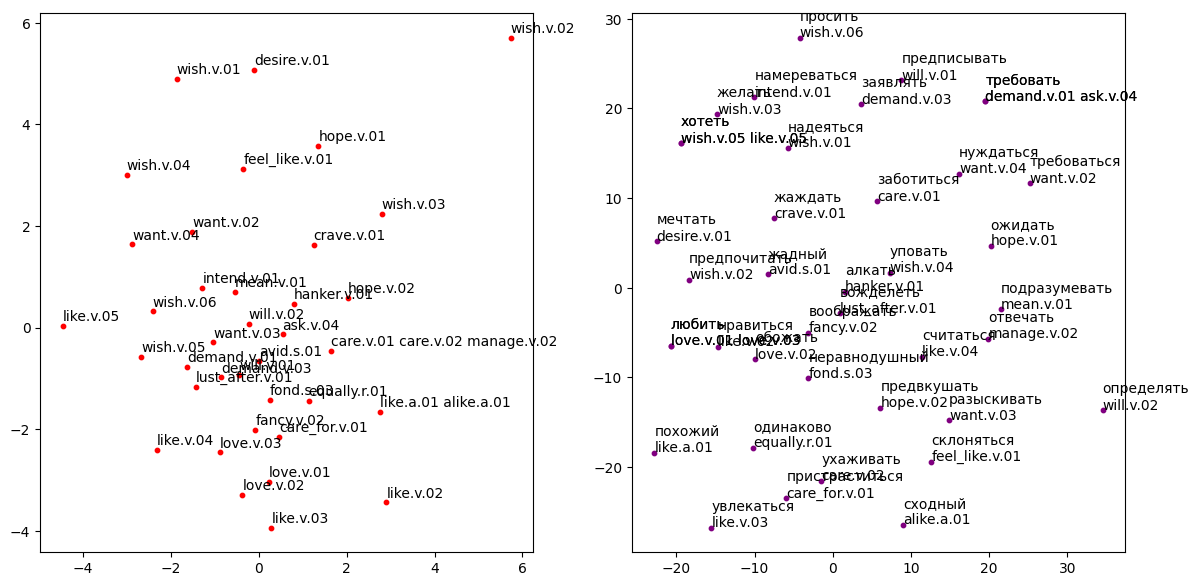

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
for pair in pairs:
    ax1.scatter(pair[0], pair[1], c='red', s=10)
    ax1.annotate(' '.join(pairs[pair]), (pair[0], pair[1] + .1))
for i, pair in enumerate(matrix_russian_transformed):
    plt.scatter(pair[0], pair[1], c='purple', s=10)
    plt.annotate(list(vectors.keys())[i].split('_')[0] + '\n' + ' '.join(list_of_russian[list(vectors.keys())[i].split('.')[0]]), (pair[0], pair[1] + .1))

*Соответствует ли взаимное расположение синсетов на «типологической» карте взаимному расположению относящихся к ним русских слов в дистрибутивной модели?*

Если коротко и в общем, то не соответствует! Если приглядеться, то можно заметить группу романтической првязанности, например... Но в остальном график русских слов еще более дисперсный!

### **Шаг 6**

In [52]:
import scipy.spatial.distance as ds

In [60]:
xarr = []
for i, pair in enumerate(matrix_transformed):
    for j in range(len(matrix_transformed)):
        if i != j:
            xarr.append(ds.cosine(pair, matrix_transformed[j]))

In [59]:
yarr = []
for i, pair in enumerate(matrix_russian_transformed):
    for j in range(len(matrix_russian_transformed)):
        if i != j:
            yarr.append(ds.cosine(pair, matrix_russian_transformed[j]))

In [61]:
np.corrcoef(xarr, yarr)

array([[ 1.        , -0.00729021],
       [-0.00729021,  1.        ]])

Как можно заметить, корреляция Пирсона очень близка к 0, поэтому можем считать, что между двумя наборами косинусных расстояний нет корреляции!